In [4]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from tqdm import tqdm
from collections import defaultdict
import copy
import random
import matplotlib.pyplot as plt

In [2]:
def tuple_to_int(action):
    return action[0] * 3 + action[1]

def int_to_tuple(position):
    return (int(position/3), position % 3)

In [9]:
str(({'X', 'O'} - set('X')).pop())

'O'

In [24]:
class QPlayer:
    def __init__(self, epsilon=0.2, alpha=0.05, gamma=0.99, player='X', explore = False, e_min = 0.1, e_max = 0.8, n_star = 20000):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
        self.alpha = alpha
        self.gamma = gamma
        # 3^9 states 9 length vectors are keys and 9 length list of values represents actions 
        #self.Qvalues = defaultdict(lambda: [0 for _ in range(9)])
        self.Qvalues = defaultdict(lambda: defaultdict(int))
        self.last_action = 0
        self.last_state = 0
        self.player2value = {'X': 1, 'O': -1}
        self.counter = 0
        self.explore = explore
        self.e_min = e_min
        self.e_max = e_max
        self.n_star = n_star
        self.other_player = str(({'X', 'O'} - set('X')).pop())

    def change_player(self):
        self.player = str(({'X', 'O'} - set(self.player)).pop())

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid):
        if self.explore:
            self.epsilon = self.decreasing_exploration(self.e_min, self.e_max, self.n_star, self.counter)
        # epsilon greedy policy w.r.t. Q-values
        if random.random() < self.epsilon:
            action = self.randomMove(grid)
            self.last_action = tuple_to_int(action)
        else:
            idx = np.argmax([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)])
            action = self.empty(grid)[idx]
            self.last_action = tuple_to_int(action)

        self.last_state = str(grid)  
        return action

    def updateQ(self, grid, reward):
        future_estimate = max([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)], default=0)
        self.Qvalues[self.last_state][self.last_action] += self.alpha * (reward + self.gamma * future_estimate - self.Qvalues[self.last_state][self.last_action]) 

    def updateQ2(self, grid, reward, s, a):
        future_estimate = max([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)], default=0)
        self.Qvalues[s][a] += self.alpha * (reward + self.gamma * future_estimate - self.Qvalues[s][a]) 
            
    def decreasing_exploration(self, e_min, e_max, n_star, n):
        return max(e_min, e_max * (1 - n/n_star)) 
            

In [14]:
def play_game(agent1, agent2, env, i, train=True):
    grid, end, __  = env.observe()
    if i % 2 == 0:
        agent1.player = 'X'
        agent2.player = 'O'
    else:
        agent1.player = 'O'
        agent2.player = 'X'
    while end == False:
        if env.current_player == agent1.player:
            move = agent1.act(grid) 
            grid, end, winner = env.step(move, print_grid=False)
        else:
            move = agent2.act(grid)
            grid, end, winner = env.step(move, print_grid=False) 
            if train:
                reward = env.reward(agent1.player)
                agent1.updateQ(grid.copy(),reward)
    return winner, agent1, agent2


def simulate(agent1, agent2, N=500, train=True, bar=True):
    env = TictactoeEnv()
    N_win = 0
    N_loose = 0
    history = []
    
    # set exploration to 0 in test environment
    if not train:
        temp_eps = agent1.epsilon
        temp_explore = agent1.explore
        agent1.epsilon = 0
        agent1.explore = False
        
    for i in tqdm(range(N), disable=not bar):
        # initialize env and players
        env.reset()
        agent1.counter += 1
        # simulation
       
        winner, agent1, agent2 = play_game(agent1, agent2, env, i, train)

        # save results
        if winner == agent1.player:
            N_win += 1
            history.append(1)
        elif winner == agent2.player:
            N_loose += 1
            history.append(-1)
        else:
            history.append(0)
    
    if not train:
        agent1.epsilon = temp_eps
        agent1.explore = temp_explore
           
    return history, (N_win - N_loose) / N, agent1
            


Q1

0.32565


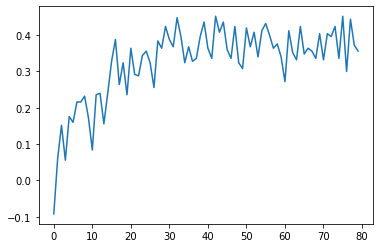

In [35]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=.5)
env = TictactoeEnv()
history, metric, agent1 = simulate(agent1, agent2, N=20000)
print(metric)
results = np.mean(np.array(history).reshape(80,250), axis=1)
plt.plot(results)

Q2

In [37]:
agents = [QPlayer(explore=True, n_star=1), QPlayer(explore=True, n_star=1000), QPlayer(explore=True, n_star=10000) ,QPlayer(explore=True, n_star=20000), QPlayer(explore=True, n_star=40000)]
all_history = []
opponent = OptimalPlayer(epsilon=0.5)
env = TictactoeEnv()
for agent in agents:
    history, metric, a = simulate(agent1, opponent, N=20000)
    print(metric)
    all_history.append(history)

100%|██████████| 20000/20000 [03:16<00:00, 101.91it/s]


0.4066


100%|██████████| 20000/20000 [03:11<00:00, 104.20it/s]


0.4132


100%|██████████| 20000/20000 [03:13<00:00, 103.12it/s]


0.4115


100%|██████████| 20000/20000 [03:13<00:00, 103.46it/s]


0.4066


100%|██████████| 20000/20000 [03:14<00:00, 102.80it/s]

0.407


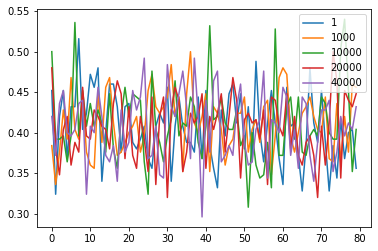

In [38]:

results1 = np.mean(np.array(all_history[0]).reshape(80,250), axis=1)
results2 = np.mean(np.array(all_history[1]).reshape(80,250), axis=1)
results3 = np.mean(np.array(all_history[2]).reshape(80,250), axis=1)
results4 = np.mean(np.array(all_history[3]).reshape(80,250), axis=1)
results5 = np.mean(np.array(all_history[4]).reshape(80,250), axis=1)
plt.plot(results1, label='1')
plt.plot(results2, label='1000')
plt.plot(results3, label='10000')
plt.plot(results4, label='20000')
plt.plot(results5, label='40000')
plt.legend()

Q3

In [44]:
def learning_evolution(agent1, agent2, N=80):
    m_opts = []
    m_rands = []
    agent_opt = OptimalPlayer(epsilon = 0)
    agent_rand = OptimalPlayer(epsilon = 1)
    
    for i in tqdm(range(N)):
        # training phase
        _, __, agent1 = simulate(agent1, agent2, N=250, train=True, bar=False)
        # testing phase
        _, m_opt, agent1 = simulate(agent1, agent_opt, N=500, train=False, bar=False)
        _, m_rand, agent1 = simulate(agent1, agent_rand, N=500, train=False, bar=False)
        #save results
        m_opts.append(m_opt)
        m_rands.append(m_rand)
           
    return m_opts, m_rands
            

100%|██████████| 80/80 [10:52<00:00,  8.15s/it]


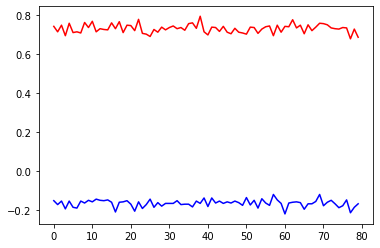

In [40]:
agent1 = QPlayer(explore= True, n_star=20000)
agent2 = OptimalPlayer(epsilon=0.5)
m_opts, m_rands = learning_evolution(agent1, agent2, N=80)
plt.plot(m_opts, color='blue')
plt.plot(m_rands, color='red')

Q4

In [52]:
agent1 = QPlayer(explore=True, n_star=1000)
opponents = [OptimalPlayer(epsilon=0), OptimalPlayer(epsilon=0.2),OptimalPlayer(epsilon=0.5),OptimalPlayer(epsilon=0.8),OptimalPlayer(epsilon=1)]
opts = []
rands = []
for opponent in opponents:
    m_opts, m_rands = learning_evolution(agent1, agent2, N=80)
    opts.append(m_opts)
    rands.append(m_rands)


100%|██████████| 80/80 [10:49<00:00,  8.11s/it]


Text(0.5, 1.0, 'Against Opt(1)')

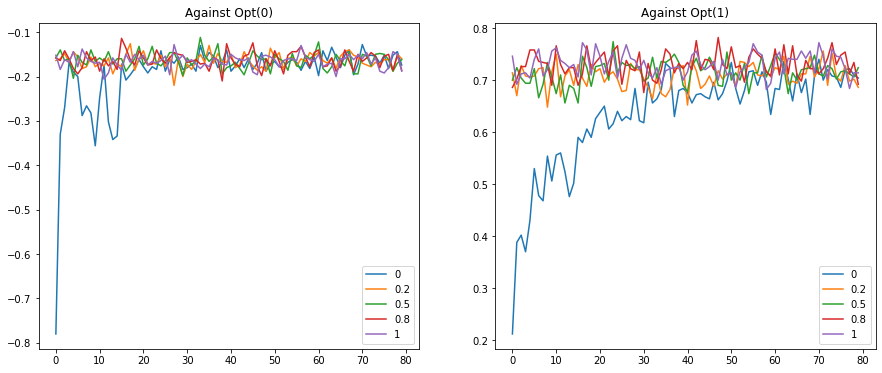

In [98]:
labels = [0, 0.2, 0.5, 0.8, 1]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
for i in range(5):
    ax[0].plot(opts[i], label=labels[i])
    ax[1].plot(rands[i], label=labels[i])
ax[0].legend()
ax[1].legend()
ax[0].set_title('Against Opt(0)')
ax[1].set_title('Against Opt(1)')

Q5

Q6

In [94]:
# This part does not work at all I was just making experiments

def self_practice(agent1, env, train=True):
    grid, end, __  = env.observe()
    agent1.player = 'X'
    while end == False:
            s, a = agent1.last_state, agent1.last_action
            move = agent1.act(grid) 
            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(agent1.player)
            agent1.updateQ2(grid.copy(),reward, s, a)
            agent1.change_player()
    return agent1


def self_learning_evolution(agent1, N=80):
    m_opts = []
    m_rands = []
    agent_opt = OptimalPlayer(epsilon = 0)
    agent_rand = OptimalPlayer(epsilon = 1)
    env = TictactoeEnv()
    
    for i in tqdm(range(N)):
        # training phase
        for j in range(250):
            env.reset()
            agent1 = self_practice(agent1, env, train=True)
        # testing phase
        _, m_opt, agent1 = simulate(agent1, agent_opt, N=500, train=False, bar=False)
        _, m_rand, agent1 = simulate(agent1, agent_rand, N=500, train=False, bar=False)
        #save results
        m_opts.append(m_opt)
        m_rands.append(m_rand)
           
    return m_opts, m_rands

In [65]:
agent1 = QPlayer(epsilon=0)
m_opts0, m_rands0 = self_learning_evolution(agent1, N=10)
agent1 = QPlayer(epsilon=0.1)
m_opts1, m_rands1 = self_learning_evolution(agent1, N=10)
agent1 = QPlayer(epsilon=0.2)
m_opts2, m_rands2 = self_learning_evolution(agent1, N=10)
agent1 = QPlayer(epsilon=0.3)
m_opts3, m_rands3 = self_learning_evolution(agent1, N=10)
agent1 = QPlayer(epsilon=0.5)
m_opts4, m_rands4 = self_learning_evolution(agent1, N=10)

100%|██████████| 10/10 [01:21<00:00,  8.19s/it]


In [60]:
env = TictactoeEnv()
agent1 = QPlayer(epsilon=0.3)
for i in tqdm(range(10000)): 
    env.reset()
    agent1, _ = self_practice(agent1, env)

100%|██████████| 10000/10000 [02:01<00:00, 82.58it/s]


In [61]:
agent_opt = OptimalPlayer(epsilon = 0)
agent_rand = OptimalPlayer(epsilon = 1)
_, m_opt, agent1 = simulate(agent1, agent_opt, N=500, train=False, bar=False)
_, m_rand, agent1 = simulate(agent1, agent_rand, N=500, train=False, bar=False)
print(m_opt)
print(m_rand)

-1.0
0.15


Deep Q Learning

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [61]:
def grid_to_tensor(grid, player='X'):
    tensor = np.zeros((3,3,2))
    grid1 = grid.copy()
    if player == 'X':
        grid1[grid == -1] = 0
        tensor[:,:,0] = grid1

        grid[grid == 1] = 0
        tensor[:,:,1] = np.abs(grid)
    else: 
        grid1[grid == 1] = 0
        tensor[:,:,0] = np.abs(grid1)

        grid[grid == -1] = 0
        tensor[:,:,1] = grid
    return torch.tensor(tensor)

def tensor_to_grid(tensor, player='X'):
    return (tensor[:,:,0] + tensor[:,:,1] * (- 1)).numpy() if player == 'X' else (tensor[:,:,0] * (- 1) + tensor[:,:,1]).numpy()
    

In [93]:
#DQN has many hyper parameters. For convenience, we fix the discount factor at
#γ = 0.99. We assume a buffer size of 10’000 and a batch size of 64. We update the target network every
#500 games. Instead of squared loss, we use the Huber loss (with δ = 1) with Adam optimizer (c.f. the
#DQN tutorials of Keras and PyTorch). You can fine tune the learning rate if needed, but we suggest
#5 × 10−4 as a starting point.

class DeepAgent:
    def __init__(self, gamma=0.99, buffer=10000, batch=64, update_target=500):
        self.gamma = gamma
        self.buffer = buffer
        self.batch = batch
        self.update_target = 500
        self.DQN = DeepQNetwork()

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        self.linear1 = nn.Linear(18, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 9)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=10e-5)
        self.criterion = nn.HuberLoss(delta=1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x